In [1]:
from scipy.io import loadmat, savemat
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad

dp = "/home/simon/Code/semester-project-fs22/denoised_0.mat"
#dp  ="/home/simon/Code/quelltext/datasets/eps_yl_w3.mat"

In [2]:
ds = loadmat(dp, variable_names=["E_filt"])
ten = ds["E_filt"]

In [3]:
def lambd(ß):
	return np.sqrt(2*(ß+1) + 8*ß/((ß+1)+np.sqrt(ß**2 + 14*ß+1)))
def intform(t, ß):
	return np.sqrt( ((1+np.sqrt(ß))**2-t) * (t-(1-np.sqrt(ß)**2)) )/(2*np.pi * t)
def intgl(u, ß):
	return quad(intform, (1-ß)**2, u, args=(ß,))[0] - 0.5

def thresh(n, m, sigmas):
	ß = n/m
	u = fsolve(func=intgl, x0=(1,), args=(ß,))
	w = lambd(ß) / u
	sig = np.median(sigmas)
	return w * sig

In [13]:
prism = Scattering2D(J=3, shape=ten.shape)
#prism = prism.to("cuda:0")

In [4]:
U, E, V = np.linalg.svd(ten)

In [5]:
t = thresh(ten.shape[0],ten.shape[1], E)

/tmp/ipykernel_3469/3081367668.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( ((1+np.sqrt(ß))**2-t) * (t-(1-np.sqrt(ß)**2)) )/(2*np.pi * t)
/tmp/ipykernel_3469/3081367668.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(intform, (1-ß)**2, u, args=(ß,))[0] - 0.5
/tmp/ipykernel_3469/3081367668.py:6: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(intform, (1-ß)**2, u, args=(ß,))[0] - 0.5
/home/simon/.local/share/virtualenvs/semester-project-fs22-Q1qTmveV/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
np.save("U", U)
np.save("V", V)

In [6]:
t

array([2337.71208065])

In [45]:
Ec = np.zeros_like(E)
Ec[E>t] = E[E>t]
Ecd = np.diag(Ec)
Ecd = np.pad(Ecd, pad_width=((0, U.shape[0]-Ec.shape[0]), (0,0)))
Ecd.shape

(29400, 5561)

In [46]:
EV = np.matmul(Ecd, V)

In [47]:
X = np.matmul(U, EV)

In [50]:
savemat("svd_denoised.mat", {"E_filt": X, "E_filled": ten})

In [54]:
ten.shape + X.shape

(29400, 5561, 29400, 5561)

In [8]:
from matplotlib import pyplot as plt

/tmp/ipykernel_3469/2360051471.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


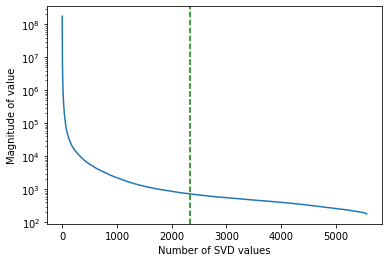

In [11]:
fig, ax = plt.subplots()
ax.set_yscale("log", base=10)
ax.set_xlabel("Number of SVD values")
ax.set_ylabel("Magnitude of value")
ax.plot(E)
ax.axvline(t, color="green", ls="--")
fig.show()

In [1]:
import numpy as np
from scipy.io import loadmat
ds = loadmat("/home/simon/Code/quelltext/datasets/eps_yl_w3.mat")

In [2]:
from src.denoiser import denoise

In [3]:
X, E, t = denoise(ds["E_filled"])

/home/simon/Code/semester-project-fs22/src/denoiser.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "denoise" failed type inference due to: Invalid use of type(CPUDispatcher(<function thresh at 0x7f59fe85dbd0>)) with parameters (int64, int64, array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function thresh at 0x7f59fe85dbd0>))
During: typing of call at /home/simon/Code/semester-project-fs22/src/denoiser.py (37)


File "src/denoiser.py", line 37:
def denoise(ten):
    <source elided>

	t = thresh(ten.shape[0], ten.shape[1], E)
 ^

  @jit(nogil=True, parallel=True)
/home/simon/.local/share/virtualenvs/semester-project-fs22-Q1qTmveV/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "denoise" was compiled in object mode without forceobj=True.

File "src/denoiser.py", line 33:
@jit(nogil=True, parallel=True)
def denoise(ten):
^

  warnings.warn(errors.NumbaWarning(war

(1100,)


/home/simon/Code/semester-project-fs22/src/denoiser.py:18: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "intgl" failed type inference due to: Untyped global name 'quad': Cannot determine Numba type of <class 'function'>

File "src/denoiser.py", line 20:
def intgl(u, ß):
	return quad(intform, (1 - ß)**2, u, args=(ß, ))[0] - 0.5
 ^

  @jit(nogil=True, parallel=True)
/home/simon/.local/share/virtualenvs/semester-project-fs22-Q1qTmveV/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "intgl" was compiled in object mode without forceobj=True.

File "src/denoiser.py", line 19:
@jit(nogil=True, parallel=True)
def intgl(u, ß):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/simon/.local/share/virtualenvs/semester-project-fs22-Q1qTmveV/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode comp

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6388 is different from 1100)

In [3]:
from src.plotter import plot
plot(ds["E_filled"], ds["E_filt"], [1], "test.png")

TS done
cf done
diag done


AttributeError: 'AxesSubplot' object has no attribute 'set_zlabel'

Error: Canceled future for execute_request message before replies were done

In [30]:
from matplotlib import pyplot as plt
from src.plotter import vip
MSIZE=0.5
from numpy import arange

def plot2f(original, denoised, name):
	#fig = plt.figure(figsize=(14, 14), dpi=300)
	fig, axs = plt.subplots(
	    1,
	    4,
	)
	fig.set_dpi(400)
	fig.set_size_inches(20, 6)
	for x in range(3):
		t = vip[name][x][0]
		des = vip[name][x][1]
		axs[x].plot(original[t, :],
		            label="Original",
		            linewidth=MSIZE,
		            alpha=0.5)
		axs[x].plot(denoised[t, :], label="Denoised", linewidth=MSIZE)
		axs[x].legend()
		axs[x].set_title(des)

	x = original.shape[1] // 2
	locs = arange(280, 280 + original.shape[0])
	s = 0.1
	axs[3].scatter(locs, denoised[:, x], label="Denoised", marker="*", s=s)
	axs[3].scatter(locs, original[:, x], label="Original", alpha=0.5, marker="*", s=s)
	axs[3].legend()
	axs[3].set_title(f"Time flow at pos {x}")
	fig.savefig(f"den-{name}.svg")

In [1]:
from src.plotter import plot2, plot
from tensorflow.keras.models import load_model
from numpy import expand_dims
from src.loader_old import load_raw, replace_nan
model = load_model("model2")
data = replace_nan(load_raw("/home/simon/Code/quelltext/datasets/steelbar/eps_yl_k3.mat")[0])

data = expand_dims(data, axis=-1)
data = expand_dims(data, axis=-1)



Loaded eps_yl_k3
imputed


1
(2686, 5422, 1, 1)
(2686, 2711, 1, 1)
(5422, 2686)
TS done
cf done
diag done
diff done


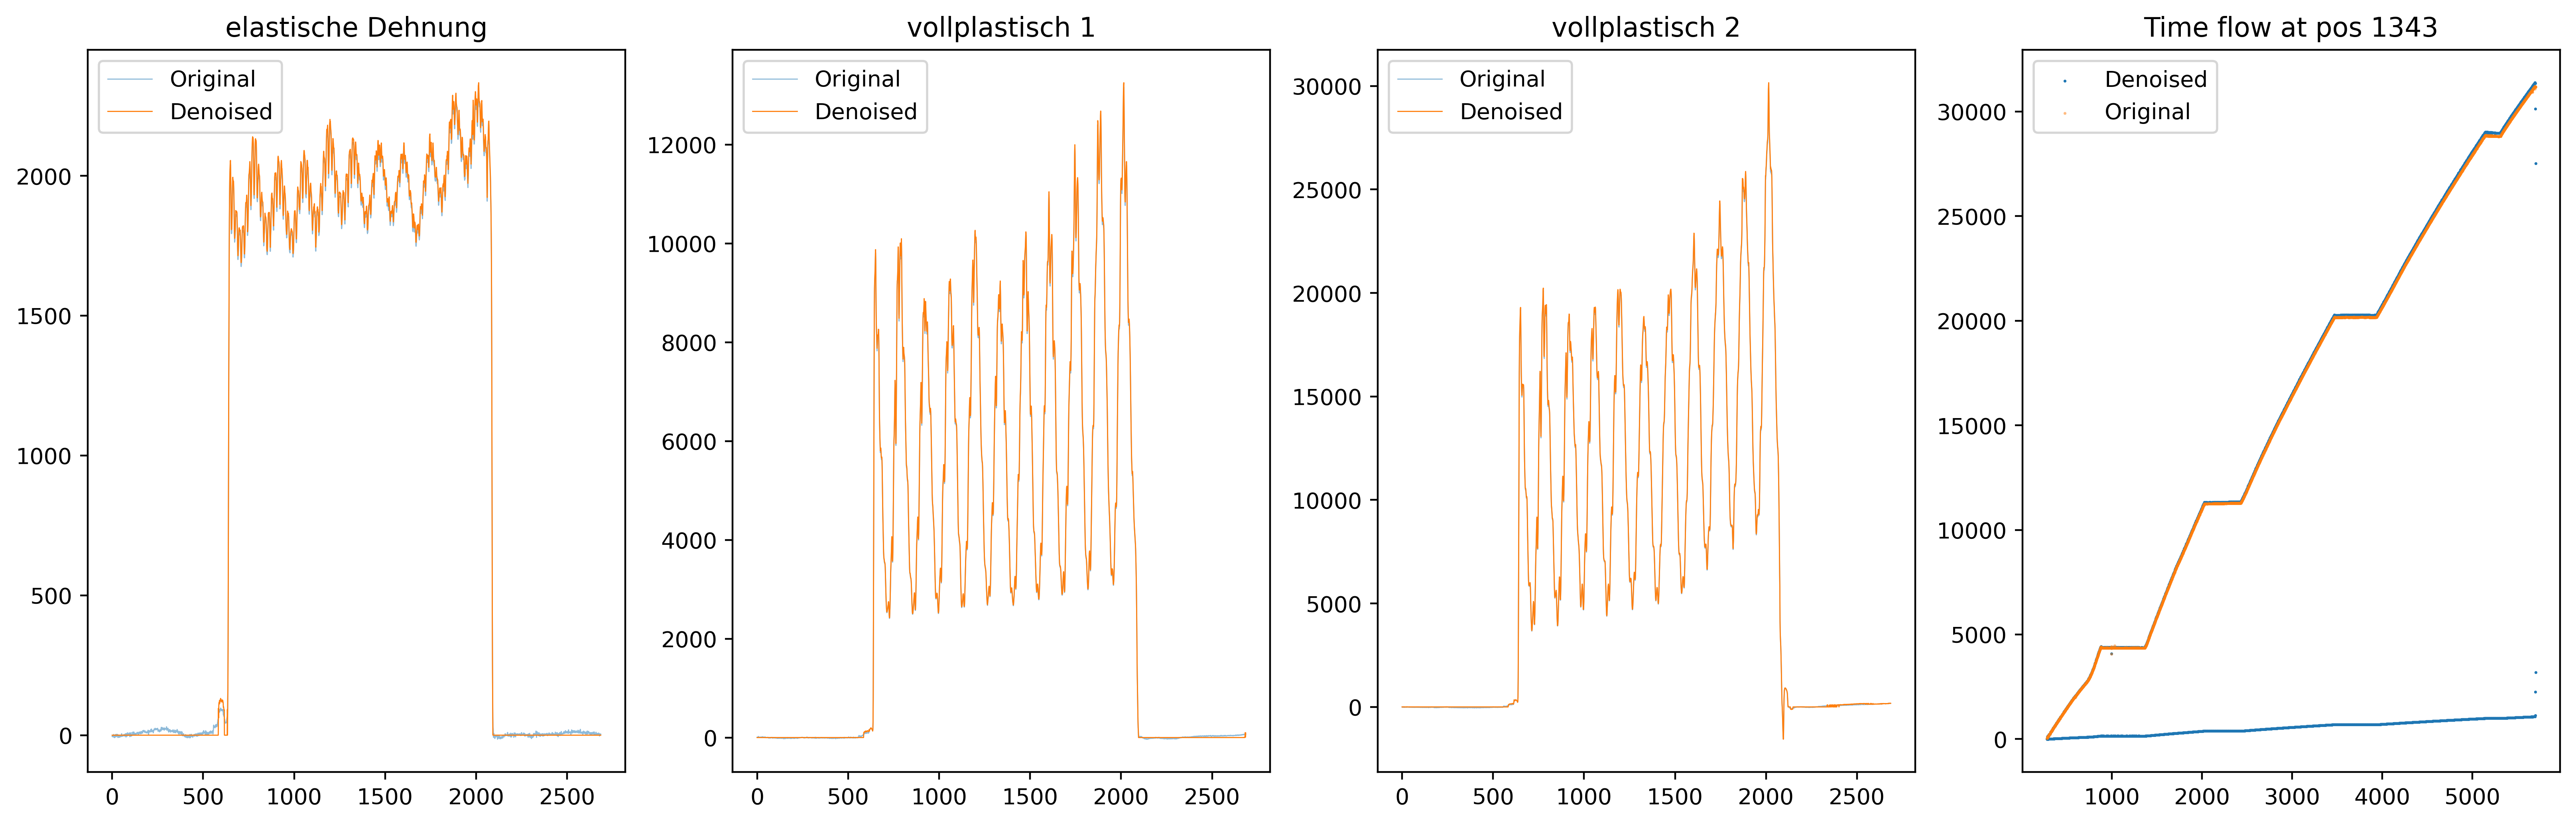

In [31]:
from numpy import squeeze, empty, zeros_like
denoised = model(data)
print(len(denoised[2]))
print(denoised[0].shape)
print(denoised[1].shape)

wav_coeffs = squeeze(denoised[1]).T[:, 2000]
denoiseds = squeeze(denoised[0]).T
datas = squeeze(data).T
print(denoiseds.shape)
plot2f(datas, denoiseds, "eps_yl_k3")
plot(datas, denoiseds, orig_sv=zeros_like(wav_coeffs), result=wav_coeffs, cutoff=0, save="comp-yl.png")